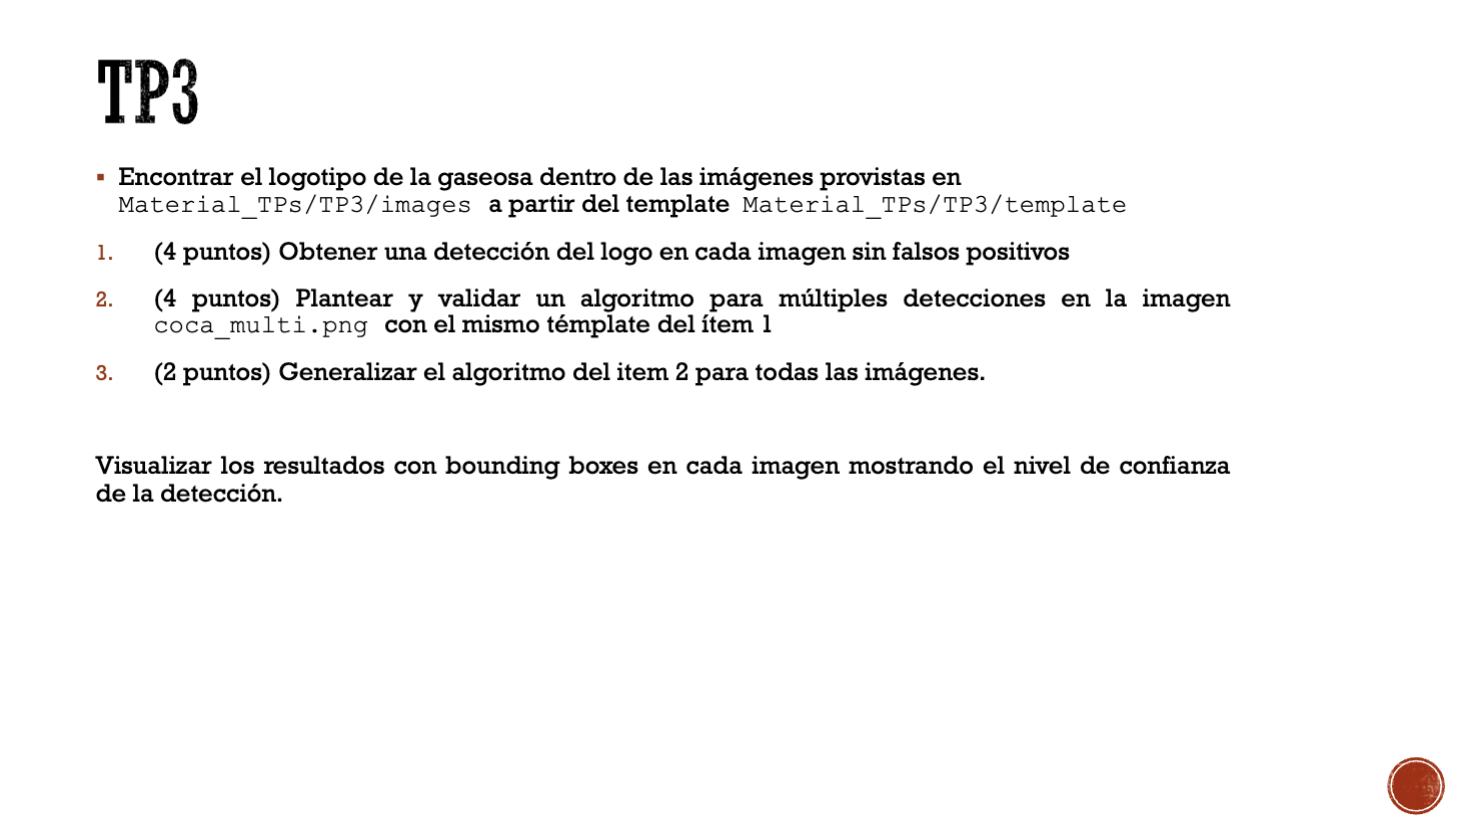

In [259]:
# Se cargan las dependencias
%matplotlib qt

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

#### 1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

Se desarrolló una función para preprocesar la imagen y facilitar la detección en las siguentes funciones del trabajo. En este preproceamiento, se utiliza un cambio de la imagen de BGR a GRAY. Luego se aplica Canny para quedarse únicamente con los bordes de la imagen. Finalmente se comprobó que el resultado mejoraba aplicando GaussianBlur, por lo que se usó al final del procesado de la imagen. 

In [260]:
def preprocess_image(input_image: np.ndarray, gb_kernel: 15.0) -> np.ndarray:
    """
    Esta función recibe una imagen y devuelve otra imagen preprocesada dejando solo los bordes suavizados sin color.

    :param input_image: imagen de entrada.
    :type input_image: np.ndarray
    """
    # Se cambia de BGR a GRAY
    if len(input_image.shape) == 3:
        img_gray = cv.cvtColor(input_image, cv.COLOR_BGR2GRAY)
    else:
        img_gray = input_image
    
    # Se usa Canny para quedarse con los bordes
    img_edges = cv.Canny(img_gray, threshold1=550, threshold2=600)

    # Se usa GaussianBlur para suavizar la imagen
    img_blur = cv.GaussianBlur(img_edges, (gb_kernel, gb_kernel), 0)
    
    return img_blur

Se creó una función llamada find_logo que recibe una imagen y un template. Busca el template en la imagen y la muestra con un bounding box sobre el logo junto con el valor correspondiente al resultado del método. Para esto se hace uso de Template Matching. Esta función solo es capaz de detectar un solo logo.

In [261]:
def find_logo(input_image: np.ndarray, template: np.ndarray):
    """
    Esta función recibe una imagen y un template. Busca el tempalte en la imagen y la muestra con 
    un bounding box sobre el logo junto con el valor correspiente al resultado del método.

    :param input_image: imagen de entrada en la cual se quiere encontrar el logo.
    :type input_image: np.ndarray

    :param template: template que contiene el logo a encontrar en la imagen.
    :type template: np.ndarray
    """

    #Se pasa de BGR a RGB, para mostrarla luego
    img_rgb = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)

    #Se preprocesa la imagen
    img_edges = preprocess_image(input_image, gb_kernel=19)

    #Se pasa de BGR a RGB, para mostrarla luego
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    #Se preprocesa la imagen
    template_edges = preprocess_image(template_gray, gb_kernel=19)

    # Se obtienen las dimensiones de las imágenes
    img_h, img_w = img_edges.shape
    template_h, template_w = template_edges.shape

    # Se calcula la escala mínima, asegurándose que el template no sea menor a 25% de la imagen.
    scale_min = min(img_w / template_w / 4, img_h / template_h / 4)

    # Se calcula la escala máxima: asegurándose que el template no sea más grande que la imagen.
    scale_max = min(img_w / template_w, img_h / template_h)

    # Se crea el rango de escalas
    scales = np.linspace(scale_min, scale_max, 100)

    # Se elige el método
    meth = 'cv.TM_CCORR_NORMED'

    # Se inicializan los valores
    best_max_val = 0
    best_res = None

    # Se itera por cada escala para encontrar el mejor valor posible
    for scale in scales:

        # Se redimensiona el template en función de la iteración de scale
        resized_img = cv.resize(template_edges, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        w, h = resized_img.shape[::-1]
        
        # Se hace una copia de la imagen para luego mostrarla y que no se superponga con otra
        img_copy = img_rgb.copy()

        # Se carga el método de evaluación
        method = eval(meth)
        
        # Se aplica template matching
        res = cv.matchTemplate(img_edges, resized_img, method)
        
        # Se encuentran los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
        # Se actualizan los valores si el valor max_val es mayor al obtenido anteriormente.
        if max_val > best_max_val:
            best_max_val = max_val
            best_w = w
            best_h = h
            best_loc = max_loc
            best_res = res

    # Se localiza la bounding box mostrando también el valor del método elegido 
    top_left = best_loc
    bottom_right = (top_left[0] + best_w, top_left[1] + best_h)
    label = f'{best_max_val:.2f}'
    (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2)
    text_end = (top_left[0] + label_width, top_left[1] - label_height)
    cv.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
    cv.rectangle(img_copy, top_left, text_end, (0, 0, 0), -1)
    cv.putText(img_copy, label, top_left, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Se crea una figura nueva
    plt.figure()

    # Se muestra el resultado de template matching
    if best_res is not None:
        plt.subplot(121), plt.imshow(best_res, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Se localiza el objeto en la imagen de entrada
    plt.subplot(122), plt.imshow(img_copy)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()

    return None 
    

Se aplica la función find_logo a las imágenes de la carpeta images que tengan un solo logo.

In [262]:
# Se carga la plantilla
template = cv.imread('template/pattern.png')

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_logo_1.png')
find_logo(img, template)

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_logo_2.png')
find_logo(img, template)

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_retro_1.png')
find_logo(img, template)

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_retro_2.png')
find_logo(img, template)

#Se carga la imagen y se busca el logo
img = cv.imread('images/COCA-COLA-LOGO.jpg')
find_logo(img, template)

#Se carga la imagen y se busca el logo
img = cv.imread('images/logo_1.png')
find_logo(img, template)

Se pudo observar que se encontró satisfactoriamente el logo en cada una de las imágenes, mostrando además su valor de correlación normalizada.

#### 2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del ítem 1

Se creó una función llamada find_multi_logo que recibe una imagen y un template. Busca los templates en la imagen y la muestra con bounding boxes sobre los logos junto con el valor correspondiente al resultado del método. Para esto se hace uso de Template Matching. Esta función es capaz de detectar múltiples logos.

In [263]:
def find_multi_logo(img: np.ndarray, template: np.ndarray, threshold: float):
    """
    Esta función recibe una imagen, un template y un valor umbral. Busca el template en la imagen y muestra la imagen con 
    un bounding boxes sobre los logos junto con el valor correspondiente al resultado del método si se superó el umbral.

    :param input_image: imagen de entrada en la cual se quiere encontrar los logos.
    :type input_image: np.ndarray

    :param template: template que contiene el logo a encontrar en la imagen.
    :type template: np.ndarray

    :param threshold: umbral que se debe superar la salida de template matching. 
    :type threshold: np.ndarray
    """

    #Se pasa de BGR a RGB, para mostrarla luego
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    #Se preprocesa la imagen
    img_edges = preprocess_image(img, gb_kernel=15)

    #Se pasa de BGR a RGB, para mostrarla luego
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    #Se preprocesa la imagen
    template_edges = preprocess_image(template_gray, gb_kernel=15)

    # Se obtienen las dimensiones de las imágenes
    img_h, img_w = img_edges.shape
    template_h, template_w = template_edges.shape

    # Se calcula la escala mínima, asegurándose que el template no sea menor a 25% de la imagen.
    scale_min = min(img_w / template_w / 8, img_h / template_h / 8)

    # Se calcula la escala máxima: asegurándose que el template no sea más grande que la imagen.
    scale_max = min(img_w / template_w, img_h / template_h)

    # Se crea el rango de escalas
    scales = np.linspace(scale_min, scale_max, 100)

    # Se elige el método
    meth = 'cv.TM_CCORR_NORMED'

    # Se inicializan los valores
    best_res = None
    best_img = None
    best_rectangle_count = 0

    # Se itera por cada escala para encontrar el mejor valor posible
    for scale in scales:

        # Se redimensiona el template en función de la iteración de scale
        resized_img = cv.resize(template_edges, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        w, h = resized_img.shape[::-1]
        
        # Se hace una copia de la imagen para luego mostrarla y que no se superponga con otra
        img_copy = img_rgb.copy()

        # Se carga el método de evaluación
        method = eval(meth)
        
        # Se aplica template matching
        res = cv.matchTemplate(img_edges, resized_img, method)

        # Se encuentran los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Se fijamos un umbral de "coincidencia"
        thres = threshold
        
        # Se localizan las coincidencias
        loc = np.where( res >= thres)

        # Se inicializa un acumulador
        rectangle_count = 0

        # Se evalúan las coincidencias para crearles un bounding box
        for pt in zip(*loc[::-1]):
            cv.rectangle(img_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
            label = f'{max_val:.2f}'
            (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2)
            text_end = (pt[0] + label_width, pt[1] - label_height)
            cv.rectangle(img_copy, pt, text_end, (0, 0, 0), -1)
            cv.putText(img_copy, label, pt, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            # Se incrementa el aucumulador
            rectangle_count += 1

        # Si el la cantidad de rectángulos encontrados es mayor al mejor histórico, entonces se actualizan los valores
        if rectangle_count > best_rectangle_count:
            best_rectangle_count = rectangle_count
            best_img = img_copy
            best_res = res


    # Se muestra la imagen
    plt.figure()
    plt.suptitle(meth)
    plt.imshow(best_img) 

    return None 
    

Se aplica la función find_multi_logo a las imágenes de la carpeta images que tengan un múltiples logos.

In [264]:
# Se carga la plantilla
template = cv.imread('template/pattern.png')

#Se carga la imagen y se buscan los logos
img = cv.imread('images/coca_multi.png')

find_multi_logo(img=img, template=template, threshold=0.61)

Se pudo observar que se encontraron 8 logos en la imagen, para ello se ajustó el parámetro de thrueshold.

#### 3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Se usa de base el algoritmo creado en el ejercicio 2 para que sea capaz de detectar también los ejemplos de un solo logo del ejercicio 1.

In [265]:
def find_logos(img: np.ndarray, template: np.ndarray, threshold: float):
    """
    Esta función recibe una imagen, un template y un valor umbral. Busca el template en la imagen y muestra la imagen con 
    un bounding boxes sobre los logos junto con el valor correspondiente al resultado del método si se superó el umbral.

    :param input_image: imagen de entrada en la cual se quiere encontrar el logo.
    :type input_image: np.ndarray

    :param template: template que contiene el logo a encontrar en la imagen.
    :type template: np.ndarray

    :param threshold: umbral que se debe superar la salida de template matching. 
    :type threshold: np.ndarray
    """

    #Se pasa de BGR a RGB, para mostrarla luego
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    #Se preprocesa la imagen
    img_edges = preprocess_image(img, 15)
    
    #Se pasa de BGR a RGB, para mostrarla luego
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    
    #Se preprocesa la imagen
    template_edges = preprocess_image(template_gray, 15)

    # Se obtienen las dimensiones de las imágenes
    img_h, img_w = img_edges.shape
    template_h, template_w = template_edges.shape

    # Se calcula la escala mínima, asegurándose que el template no sea menor a 25% de la imagen.
    scale_min = min(img_w / template_w / 4, img_h / template_h / 4)

    # Se calcula la escala máxima: asegurándose que el template no sea más grande que la imagen.
    scale_max = min(img_w / template_w, img_h / template_h)

    # Se crea el rango de escalas
    scales = np.linspace(scale_min, scale_max, 100)

    # Se elige el método
    meth = 'cv.TM_CCORR_NORMED'

    # Se inicializan los valores
    best_res = None
    best_img = None
    res_is_none = 0
    best_rectangle_count = 0

    # Mientras que no se encuentre una coincidencia en 3 ocasiones, entonces se continua, sino (se encuetra) sale del bucle
    while res_is_none<3:

        # Se itera por cada escala para encontrar el mejor valor posible
        for scale in scales:

            # Se redimensiona el template en función de la iteración de scale
            resized_img = cv.resize(template_edges, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
            w, h = resized_img.shape[::-1]
            
            # Se hace una copia de la imagen para luego mostrarla y que no se superponga con otra
            img_copy = img_rgb.copy()

            # Se carga el método de evaluación
            method = eval(meth)
            
            # Se aplica template matching
            res = cv.matchTemplate(img_edges, resized_img, method)

            # Se encuentran los valores máximos y mínimos
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

            # Se fija un umbral de "coincidencia"
            thres = threshold
            
            # Se localizan las coincidencias
            loc = np.where( res >= thres)

            # Se inicializa un acumulador
            rectangle_count = 0
            
            # Se evalúan las coincidencias para crearles un bounding box
            for pt in zip(*loc[::-1]):
                cv.rectangle(img_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
                label = f'{max_val:.2f}'
                (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2)
                text_end = (pt[0] + label_width, pt[1] - label_height)
                cv.rectangle(img_copy, pt, text_end, (0, 0, 0), -1)
                cv.putText(img_copy, label, pt, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # Se incrementa el aucumulador
                rectangle_count += 1

            # Si el la cantidad de rectángulos encontrados es mayor al mejor histórico, entonces se actualizan los valores
            if rectangle_count > best_rectangle_count:
                best_rectangle_count = rectangle_count
                best_img = img_copy
                best_res = res

        # Si no se encontró una coincidencia con Template Matching se debe achicar la escala del mínimo y del máximo para
        # tener un template más chico y volver a buscar
        if best_res is None:
            # Se calcula la escala mínima, dividiendo la escala anterior a la mitad
            scale_min = scale_min/2

            # Se calcula la escala máxima:  dividiendo la escala anterior a la mitad
            scale_max = scale_max/2

            # Se crea el nuevo rango de escalas
            scales = np.linspace(scale_min, scale_max, 10)

            # Se incrementa un contador de de que no se encontró un res
            res_is_none += 1 
        else:
            break

    # Se se tiene una coincidencia se muestra la imagen con el bounding box
    if best_res is not None:
        plt.figure()
        plt.suptitle(meth)
        plt.imshow(best_img) 
    else:
        print('No se encontró una coincidencia, por favor, cambie el valor de umbral')

    return None 
    

Se aplica la función find_logos a todas las imágenes de la carpeta images.

In [266]:
# Se carga la plantilla
template = cv.imread('template/pattern.png')

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_logo_1.png')
find_logos(img, template=template, threshold=0.72)

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_logo_2.png')
find_logos(img, template=template, threshold=0.65)

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_retro_1.png')
find_logos(img, template=template, threshold=0.61)

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_retro_2.png')
find_logos(img, template=template, threshold=0.75)

#Se carga la imagen y se busca el logo
img = cv.imread('images/COCA-COLA-LOGO.jpg')
find_logos(img, template=template, threshold=0.49)

#Se carga la imagen y se busca el logo
img = cv.imread('images/logo_1.png')
find_logos(img, template=template, threshold=0.49)

#Se carga la imagen y se busca el logo
img = cv.imread('images/coca_multi.png')
find_logos(img=img, template=template, threshold=0.61)

Se puedo observar que se encontró el logo tanto para imágenes con un solo logo como para multiples logos. Para mostrar los mejores resultados con mayor nivel de confianza se ajustó el parámetro del umbral.

In [267]:
# Para cerrar todas las ventanas
plt.close('all')
cv.destroyAllWindows()